In [1]:
# Code Versions: Multi-step predictions
# Data 1: Crypto Dataset (Bitcoin & Ethereum)
# Version 1: Linear Regression vs Quantile Regression (Baseline)

# 	Data: 	BTC - univariate & multivariate
#			ETH - univariate & multivariate

In [2]:
# import libraries 
import pandas as pd                                          # for reading dataset
import numpy as np
from sklearn.model_selection import train_test_split         # for shuffling & splitting data

from sklearn.linear_model import LinearRegression            # for model fitting
from sklearn.metrics import mean_absolute_percentage_error   # for model evaluation

import matplotlib.pyplot as plt                              # for results visualisation

In [3]:
## READ DATA
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')

In [4]:
## DATA PREPARATION
Bitcoin["Date"] = pd.to_datetime(Bitcoin["Date"]).dt.normalize() # Changing Date to appropriate format (Object -> datetime64[ns])

In [5]:
Close_Price = Bitcoin.iloc[:, 7].copy() # we are only interested in close price

In [6]:
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

In [7]:
# Usage
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

In [8]:
X_train, X_test, y_train, y_test = split_series(Close_Price, input_size, output_size, train_ratio, seed)

In [9]:
model = LinearRegression()

In [10]:
model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = model.predict(X_test)

In [12]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on test set: {mape}")

MAPE on test set: 0.07810330281850204


In [13]:
# y_pred

In [14]:
# y_test

In [15]:
time_steps = [1, 2, 3]

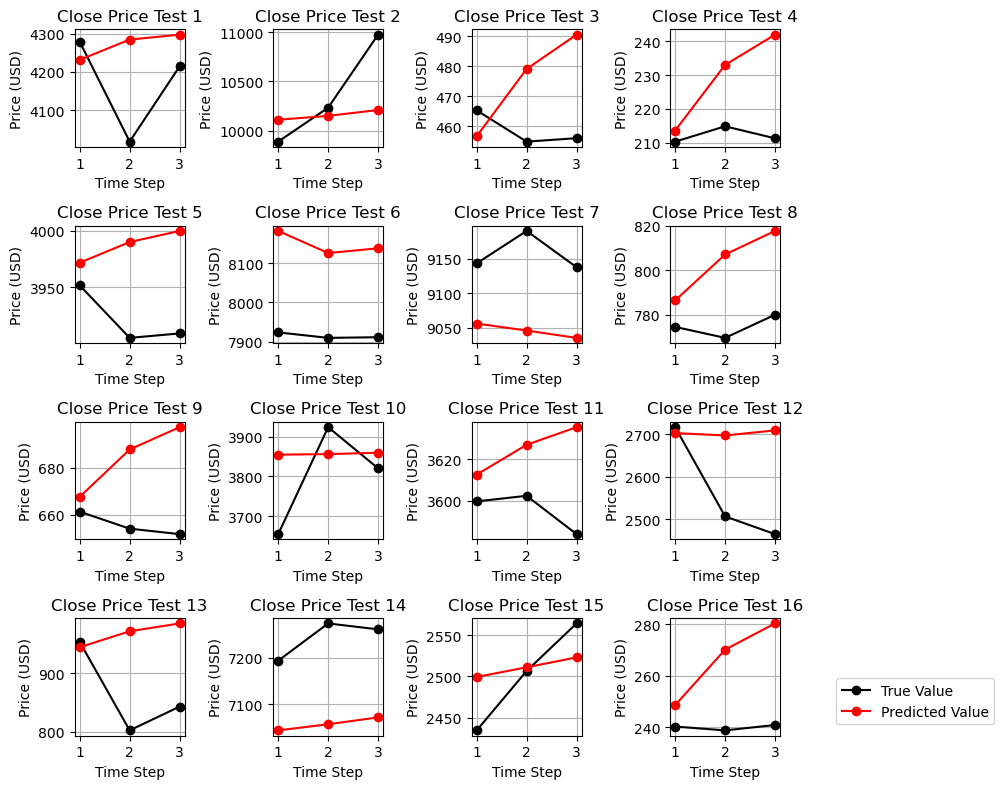

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, y_test[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, y_pred[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [17]:
num_experiments = 30 # ensure result is consistent
mape = []
seed = 5925

In [18]:
for i in range(num_experiments):
    seed += 1
    X_train, X_test, y_train, y_test = split_series(Close_Price, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))
    print(f"Experiment {i+1}: MAPE on test set: {mape[i]}")

print(f"Univariate Linear Regression Avg MAPE: {np.mean(mape)*100:.3f}%")

Experiment 1: MAPE on test set: 0.0567695650446348
Experiment 2: MAPE on test set: 0.07635565260209538
Experiment 3: MAPE on test set: 0.06383722340121763
Experiment 4: MAPE on test set: 0.07310873991850857
Experiment 5: MAPE on test set: 0.06391005162502589
Experiment 6: MAPE on test set: 0.04321051889090469
Experiment 7: MAPE on test set: 0.07238416281285497
Experiment 8: MAPE on test set: 0.05026616248211952
Experiment 9: MAPE on test set: 0.051503702018626085
Experiment 10: MAPE on test set: 0.071059745117101
Experiment 11: MAPE on test set: 0.08044091197055943
Experiment 12: MAPE on test set: 0.055573254000241094
Experiment 13: MAPE on test set: 0.07384411822014782
Experiment 14: MAPE on test set: 0.05809004962157336
Experiment 15: MAPE on test set: 0.06963487207945007
Experiment 16: MAPE on test set: 0.06354914828614533
Experiment 17: MAPE on test set: 0.07172004520864693
Experiment 18: MAPE on test set: 0.07162849271718517
Experiment 19: MAPE on test set: 0.057564362526729834
Ex

In [19]:
## Quantile Regression - Univariate BTC

In [20]:
# Usage
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

In [21]:
X_train, X_test, y_train, y_test = split_series(Close_Price, input_size, output_size, train_ratio, seed)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [22]:
from scipy.optimize import minimize

In [23]:
# tilted loss function - crux of quantile regression
def tilted_loss(beta, X, y, tau):
    y_pred = np.dot(X, beta.reshape(X.shape[1], -1)) # multi step ahead version
    u = y - y_pred
    loss = np.where(u >= 0, tau * u, (tau - 1) * u)
    return np.sum(loss)

In [24]:
quantile = [0.05, 0.25, 0.5, 0.75, 0.95]

In [25]:
# Use a dictionary to store the results
results = {
    0.05: [],
    0.25: [],
    0.5:  [],
    0.75: [],
    0.95: []
}

In [26]:
# Minimize the tilted loss
for i in quantile:
    
    # Initial guess for beta (linear regression coefficients)
    initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
    result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, i), method='BFGS')
    beta_hat = result.x.reshape(X_train.shape[1], output_size)
    # Evaluate the model
    y_pred_train = np.dot(X_train, beta_hat)
    y_pred_test = np.dot(X_test, beta_hat)

    # Calculate the tilted loss on the test set
    test_loss = tilted_loss(beta_hat.flatten(), X_test, y_test, i)
    
    # print("Optimal Beta:", beta_hat)
    # print("Test Loss:", test_loss)

    results[i] = y_pred_test

    # Print first few predictions for inspection
    print(f"Quantile {i}: First few test predictions")
    print(y_pred_test[:5])

print('Actual Values: First few test predictions')
print(y_test[:5])

Quantile 0.05: First few test predictions
[[4015.75269855 3916.36871458 3695.00963212]
 [9475.92474756 9042.0054792  8898.16809303]
 [ 416.50298091  399.58948275  388.76786516]
 [ 181.99729583  182.79755171  177.88188814]
 [3696.62251899 3591.55692415 3481.68935104]]
Quantile 0.25: First few test predictions
[[4175.18660904 4150.52966442 4142.06404743]
 [9899.53908747 9807.01358377 9823.27448616]
 [ 436.11358129  430.33549329  429.39164844]
 [ 194.89956297  193.69680712  189.31472608]
 [3887.84215108 3844.99267061 3818.36180416]]
Quantile 0.5: First few test predictions
[[ 4232.15028314  4250.05514049  4245.95374725]
 [10088.72670424 10196.78462278 10142.54609482]
 [  444.32924027   445.28967387   444.57499515]
 [  200.78549976   200.5167959    199.81792561]
 [ 3968.2845498   3974.13001739  3967.01804005]]
Quantile 0.75: First few test predictions
[[ 4338.43742948  4364.9980913   4434.27693192]
 [10286.55082248 10500.6648918  10542.96686692]
 [  454.25497603   462.98241196   465.206280

In [27]:
results[0.05]

array([[4015.75269855, 3916.36871458, 3695.00963212],
       [9475.92474756, 9042.0054792 , 8898.16809303],
       [ 416.50298091,  399.58948275,  388.76786516],
       ...,
       [7522.15534448, 7301.61218953, 7123.39059309],
       [ 220.76459845,  215.11558261,  206.03537652],
       [ 300.30549112,  292.02831183,  284.55079294]])

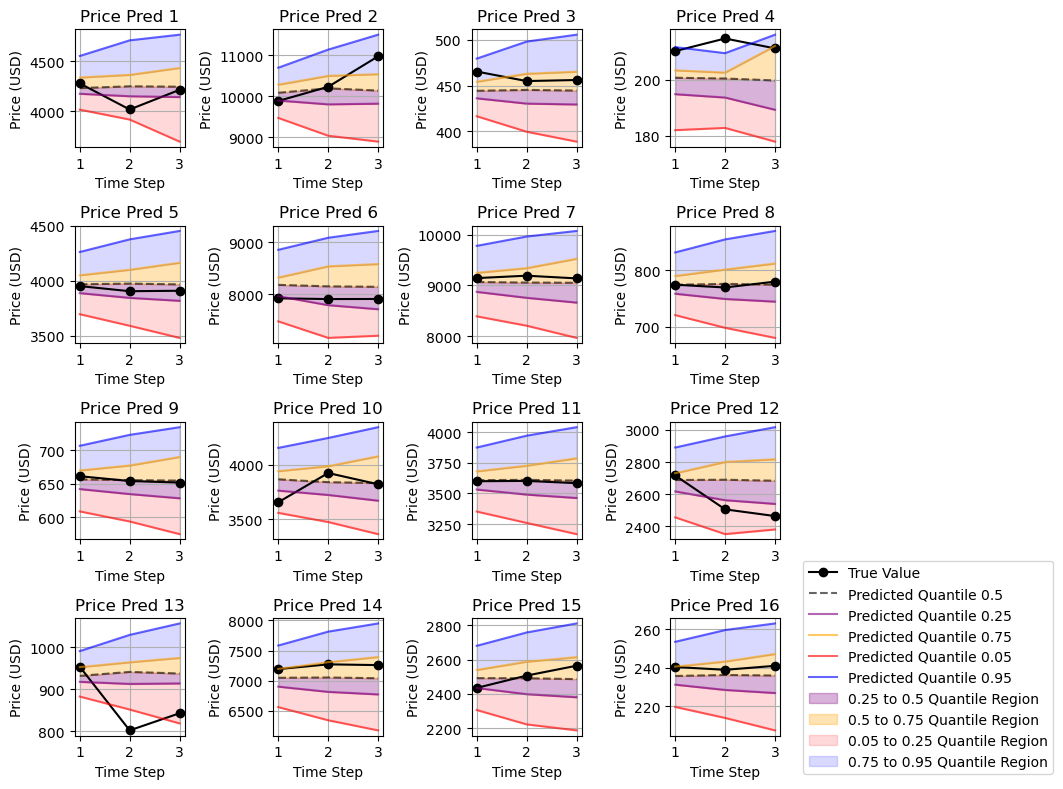

In [28]:
time_steps = [1, 2, 3]
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, y_test[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, results[0.5][i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, results[0.25][i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, results[0.75][i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, results[0.05][i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, results[0.95][i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, results[0.25][i], results[0.5][i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, results[0.5][i], results[0.75][i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, results[0.05][i], results[0.25][i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, results[0.75][i], results[0.95][i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [29]:
num_experiments = 30
seed = 5925
mape = []

In [30]:
quantile = [0.05, 0.25, 0.5, 0.75, 0.95]

In [31]:
for i in range(num_experiments):
    seed += 1
    X_train, X_test, y_train, y_test = split_series(Close_Price, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {
        0.05: [],
        0.25: [],
        0.5:  [],
        0.75: [],
        0.95: []
    }

    for q in quantile:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_train = np.dot(X_train, beta_hat)       # Evaluate the model
        y_pred_test = np.dot(X_test, beta_hat)
        test_loss = tilted_loss(beta_hat.flatten(), X_test, y_test, q)
        results[q] = y_pred_test

    mape.append(mean_absolute_percentage_error(y_test, results[0.5]))
    print(f"Experiment {i+1} MAPE on test set: {mape[i]}")

print(f"Univariate Quantile Regression Avg MAPE - Quantile Ver: {np.mean(mape)*100:.3f}%")

Experiment 1 MAPE on test set: 0.038984075116046846
Experiment 2 MAPE on test set: 0.039199972070977904
Experiment 3 MAPE on test set: 0.039381115942114304
Experiment 4 MAPE on test set: 0.04162766482301545
Experiment 5 MAPE on test set: 0.039333616385785385
Experiment 6 MAPE on test set: 0.03930451037359394
Experiment 7 MAPE on test set: 0.03802825817664097
Experiment 8 MAPE on test set: 0.03796533839272396
Experiment 9 MAPE on test set: 0.0380958877143216
Experiment 10 MAPE on test set: 0.03854587681869582
Experiment 11 MAPE on test set: 0.04021188801394667
Experiment 12 MAPE on test set: 0.03671617799672389
Experiment 13 MAPE on test set: 0.036820960981331204
Experiment 14 MAPE on test set: 0.04018525623277108
Experiment 15 MAPE on test set: 0.037603699390126116
Experiment 16 MAPE on test set: 0.03951395467336475
Experiment 17 MAPE on test set: 0.04000277141626918
Experiment 18 MAPE on test set: 0.03728760057530229
Experiment 19 MAPE on test set: 0.03668180802227344
Experiment 20 MA

In [32]:
## BTC - multivariate version
## linear regression
# from sklearn.preprocessing import MinMaxScaler

In [33]:
data = Bitcoin.iloc[:, 4:]

In [34]:
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
# features = MinMaxScaler().fit_transform(features)
target = data['Close']

In [35]:
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

In [36]:
def split_data(data, input_size, output_size, train_ratio, seed):
    X, y = [], [] 
    total_size = input_size + output_size
    for i in range(len(data) - total_size + 1):
        X.append(features[i:i + input_size])                            
        y.append(target[i + input_size:i + total_size])        
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

In [37]:
X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [38]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [39]:
model = LinearRegression()
model.fit(X_train_reshaped, y_train)

LinearRegression()

In [40]:
y_pred = model.predict(X_test_reshaped)

In [41]:
y_pred

array([[4266.0610637 , 4355.10761306, 4306.19662597],
       [9986.63453793, 9965.63692467, 9937.01219957],
       [ 438.67415498,  464.45732128,  470.70525977],
       ...,
       [8031.94699997, 8193.04303624, 8198.92084878],
       [ 246.24303569,  255.20946921,  254.84469144],
       [ 328.33999525,  338.5170575 ,  342.56437606]])

In [42]:
y_test

array([[ 4278.84645524,  4017.26845712,  4214.67193177],
       [ 9888.61035156, 10233.59960938, 10975.59960938],
       [  465.3210144 ,   454.93399048,   456.07800293],
       ...,
       [ 8192.49400532,  8144.19451744,  8827.76442606],
       [  257.3210144 ,   234.82499695,   233.84300232],
       [  320.04598999,   328.20599365,   352.68399048]])

In [43]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on test set: {mape}") 
# Without Normalisation: 0.0628879547792754
# With Normalisation: 0.06288795076256944 (does minimal)

MAPE on test set: 0.05798883691005735


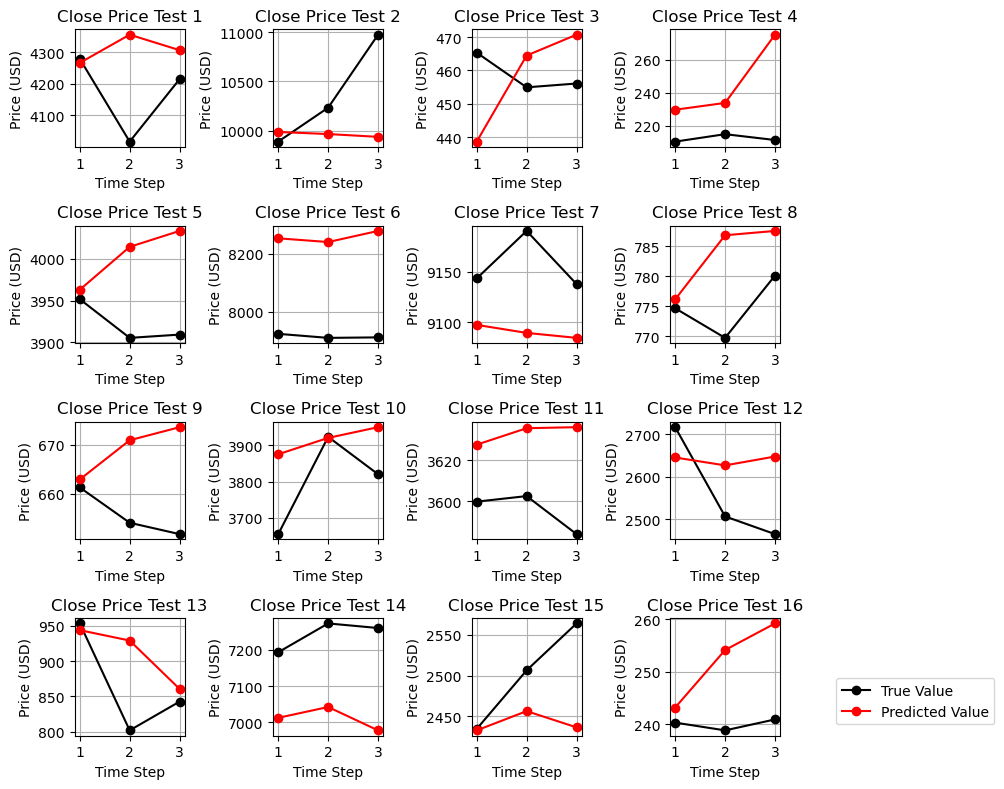

In [44]:
time_steps = [1, 2, 3]
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, y_test[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, y_pred[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [45]:
# Notice that first point prediction is pretty freaking good, accuracy drops off with further time steps
# That is to be expected, is there a way to measure this?

# How do you determine the size of input/output?
# What is a good way to evaluate quantile regression model? MAPE only compares the median with actual data, what about the other quantiles?

In [46]:
num_experiments = 30 # ensure result is consistent
mape = []
seed = 5925

In [47]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    model = LinearRegression()
    model.fit(X_train_reshaped, y_train)
    y_pred = model.predict(X_test_reshaped)
    mape.append(mean_absolute_percentage_error(y_test, y_pred))
    print(f"Experiment {i+1}: MAPE on test set: {mape[i]}")
    seed += 1

print(f"Multivariate Linear Regression Avg MAPE: {np.mean(mape)*100:.3f}%")

Experiment 1: MAPE on test set: 0.060563424772486475
Experiment 2: MAPE on test set: 0.0638054916638139
Experiment 3: MAPE on test set: 0.054264711596611004
Experiment 4: MAPE on test set: 0.06166632580929134
Experiment 5: MAPE on test set: 0.06813178752132203
Experiment 6: MAPE on test set: 0.04700748244618167
Experiment 7: MAPE on test set: 0.04640777996848741
Experiment 8: MAPE on test set: 0.059778400345758674
Experiment 9: MAPE on test set: 0.050847273150316945
Experiment 10: MAPE on test set: 0.06300989748668645
Experiment 11: MAPE on test set: 0.045490995122860894
Experiment 12: MAPE on test set: 0.049694410920867176
Experiment 13: MAPE on test set: 0.05830158497446292
Experiment 14: MAPE on test set: 0.0480474319881963
Experiment 15: MAPE on test set: 0.06648527258309678
Experiment 16: MAPE on test set: 0.04820855311712061
Experiment 17: MAPE on test set: 0.06430116174959706
Experiment 18: MAPE on test set: 0.06041572429380718
Experiment 19: MAPE on test set: 0.0557553062955769

In [48]:
## Multivariate case: Quantile Regression version

In [54]:
from sklearn.preprocessing import MinMaxScaler

In [249]:
# Never give up...
data = Bitcoin.iloc[:, 4:]

features = data[['High', 'Low', 'Open', 'Close']]
# features = MinMaxScaler().fit_transform(features)
target = data['Close']

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

def split_data(data, input_size, output_size, train_ratio, seed):
    X, y = [], [] 
    total_size = input_size + output_size
    for i in range(len(data) - total_size + 1):
        X.append(features[i:i + input_size])                            
        y.append(target[i + input_size:i + total_size])        
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

from scipy.optimize import minimize

quantile = [0.05, 0.25, 0.5, 0.75, 0.95]

# Use a dictionary to store the results
results = {
    0.05: [],
    0.25: [],
    0.5:  [],
    0.75: [],
    0.95: []
}

In [251]:
def tilted_loss(beta, X, y, tau):
    y_pred = np.dot(X, beta.reshape(X.shape[1], y.shape[1]))    
    u = y - y_pred
    loss = np.where(u >= 0, tau * u, (tau - 1) * u)
    return np.sum(loss)

In [253]:
for i in quantile:
    initial_beta = np.zeros((X_train.shape[1] * X_train.shape[2], output_size)).flatten()
    result = minimize(tilted_loss, initial_beta, args=(X_train_reshaped, y_train, i), method = 'BFGS')
    beta_hat = result.x.reshape((X_train_reshaped.shape[1], output_size))
    # Evaluate the model
    y_pred_train = np.dot(X_train_reshaped, beta_hat)
    y_pred_test = np.dot(X_test_reshaped, beta_hat)

    # Calculate the tilted loss on the test set
    test_loss = tilted_loss(beta_hat.flatten(), X_test_reshaped, y_test, i)
    
    # print("Optimal Beta:", beta_hat)
    # print("Test Loss:", test_loss)

    results[i] = y_pred_test

    # Print first few predictions for inspection
    print(f"Quantile {i}: First few test predictions")
    print(y_pred_test[:5])

print('Actual Values: First few test predictions')
print(y_test[:5])

Quantile 0.05: First few test predictions
[[4011.45857951 3945.02127693 3777.2200531 ]
 [9619.11538865 9105.85535918 8951.8894937 ]
 [ 415.49213608  401.97470237  414.69695501]
 [ 182.50938714  174.50877366  165.8278936 ]
 [3792.59545148 3705.30266764 3583.1333205 ]]
Quantile 0.25: First few test predictions
[[4131.94803782 4044.08407153 4032.3685615 ]
 [9813.33284244 9697.93174504 9668.15304502]
 [ 434.22428134  422.37391517  444.79633905]
 [ 197.38998685  188.70426094  186.53988139]
 [3900.61565502 3906.07879274 3837.37474433]]
Quantile 0.5: First few test predictions
[[ 4224.955763    4287.86036851  4327.86979694]
 [10052.61142404 10184.90128595 10082.77377326]
 [  442.34521621   455.15727036   454.09117366]
 [  199.32099504   207.53541698   210.3584575 ]
 [ 3956.70647406  3960.2225661   4002.46669936]]
Quantile 0.75: First few test predictions
[[ 4371.72470852  4489.33161619  4504.2589365 ]
 [10359.77165873 10477.33216247 10676.14186158]
 [  453.55198545   462.48612407   457.384037

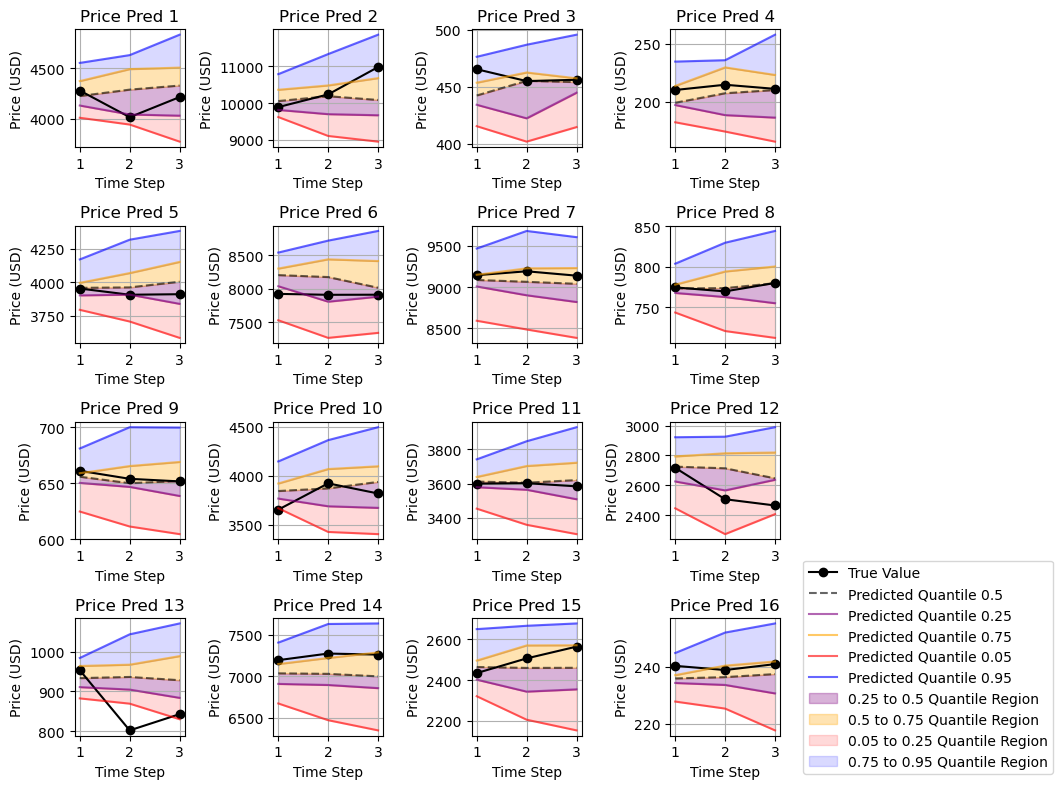

In [254]:
time_steps = [1, 2, 3]
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, y_test[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, results[0.5][i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, results[0.25][i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, results[0.75][i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, results[0.05][i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, results[0.95][i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, results[0.25][i], results[0.5][i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, results[0.5][i], results[0.75][i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, results[0.05][i], results[0.25][i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, results[0.75][i], results[0.95][i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [59]:
# Multivariate nature - feature selection is probably needed in order to perform better than univariate
# because there are more noises

# Perhaps there are more variables to consider so the prediction became more "unclear"?
# This issue is also evident in related paper, where their RMSE significantly increased for multivariate version

In [257]:
mape = mean_absolute_percentage_error(y_test, results[0.5])
print(f"Multivariate Quantile Regression Avg MAPE: {mape*100:.3f} %")

Univariate Linear Regression Avg MAPE - Quantile Ver: 4.292 %


In [243]:
## Testing various features combinations... Inefficiently
data = Bitcoin.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close']]
# features = MinMaxScaler().fit_transform(features)
target = data['Close']

def split_data(data, input_size, output_size, train_ratio, seed):
    X, y = [], [] 
    total_size = input_size + output_size
    for i in range(len(data) - total_size + 1):
        X.append(features[i:i + input_size])                            
        y.append(target[i + input_size:i + total_size])        
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

from scipy.optimize import minimize

In [245]:
num_experiments = 10
mape = []
seed = 5925

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8

In [247]:
for exp in range(num_experiments):
    
    X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

    quantile = [0.05, 0.25, 0.5, 0.75, 0.95]

    # Use a dictionary to store the results
    results = {
        0.05: [],
        0.25: [],
        0.5:  [],
        0.75: [],
        0.95: []
    }
    
    for i in quantile:
        initial_beta = np.zeros((X_train.shape[1] * X_train.shape[2], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train_reshaped, y_train, i), method = 'BFGS')
        beta_hat = result.x.reshape((X_train_reshaped.shape[1], output_size))
        
        # Evaluate the model
        y_pred_train = np.dot(X_train_reshaped, beta_hat)
        y_pred_test = np.dot(X_test_reshaped, beta_hat)
    
        # Calculate the tilted loss on the test set
        test_loss = tilted_loss(beta_hat.flatten(), X_test_reshaped, y_test, i)
    
        results[i] = y_pred_test
    
    mape.append(mean_absolute_percentage_error(y_test, results[0.5]))
    print(f"Experiment {exp+1} Multivariate Quantile Regression Avg MAPE: {mape[exp]*100:.3f} %")
    seed += 1

print(f"Multivariate Quantile Regression Average MAPE: {np.mean(mape)*100:.3f}%")

Experiment 1 Multivariate Quantile Regression Avg MAPE: 4.292 %
Experiment 2 Multivariate Quantile Regression Avg MAPE: 4.071 %
Experiment 3 Multivariate Quantile Regression Avg MAPE: 4.090 %
Experiment 4 Multivariate Quantile Regression Avg MAPE: 4.014 %
Experiment 5 Multivariate Quantile Regression Avg MAPE: 4.235 %
Experiment 6 Multivariate Quantile Regression Avg MAPE: 4.039 %
Experiment 7 Multivariate Quantile Regression Avg MAPE: 4.079 %
Experiment 8 Multivariate Quantile Regression Avg MAPE: 4.006 %
Experiment 9 Multivariate Quantile Regression Avg MAPE: 3.925 %
Experiment 10 Multivariate Quantile Regression Avg MAPE: 3.918 %
Multivariate Quantile Regression Average MAPE: 4.067%


In [ ]:
# Normalised, features = data[['High', 'Low', 'Open', 'Volume', 'Marketcap']]: 12.396 %
# Normalised, features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]: 12.271 %
# Unnormalised, features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]: 21.202%
# Normalised, features = data[['High', 'Low', 'Open', 'Volume']] - 14.4%
# Normalised, features = data[['High', 'Low', 'Open', 'Close', 'Volume']] - 13.794%
# Normalised, features = data[['High', 'Low', 'Open']] - 14.26%
# Normalised, features = data[['High', 'Low']] - 13.9%
# Normalised, features = data[['Open', 'Volume']] - 14.28%
# Normalised, features = data[['Close']] - 13.717% --- univariate case? How come MAPE still high?

# (Normalisation is affecting result)
# Unnormalised, features = data[['Close']] -- AVG: 3.931% (10 Experiments), AVG: 3.884% (30 Experiments)
# Unnormalised, features = data[['High', 'Low', 'Open', 'Close']] -- AVG: 4.067% (10 Experiments)
# Unnormalised, features = data[['High', 'Low', 'Close']] -- AVG: 4.023% (10 Experiments)